In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle 
import numpy as np
import pandas as pd
import torch
import os
from timeit import default_timer as timer

from sklearn.manifold import TSNE

In [3]:
from core.SimpleNet import SimpleNet
from core.OldGraphConvNet2 import OldGraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph
from core.EmbeddingDataSet import EmbeddingDataSet
from util.plot_embedding import plot_embedding, plot_embedding_subplot
from util.evaluation_metrics import evaluate_net_metrics, evaluate_embedding_metrics
from core.DimReduction import DimReduction

In [4]:
if torch.cuda.is_available():
    print('cuda available')
    device = 'cuda'
else:
    print('cuda not available')
    device = 'cpu'

cuda not available


In [5]:
dataset_name = 'cora'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir)
dataset.create_all_train_data(shuffle=True)
dataset.summarise()

Name of dataset = cora
Input dimension = 1433
Number of training samples = 2708
Training labels = True
Graph information = True


In [6]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = dataset.input_dim # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 10 # number of hidden layers

In [12]:
# Graph net
net_1 = OldGraphConvNet2(net_parameters)
if torch.cuda.is_available(): net_1.cuda()
root = 'results/cora_1/'
filename = root + 'graph_net_500.pkl'
checkpoint = torch.load(filename, map_location=device)
net_1.load_state_dict(checkpoint['state_dict'])
net_1.eval()

trustworthiness, one_nn, five_nn, time_elapsed = evaluate_net_metrics(dataset.all_train_data, net_1, 'cosine')
print("Trustworthy score = {:.4f}".format(trustworthiness))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn))
print("5-NN generalisation accuracy = {:.4f}".format(five_nn))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

Trustworthy score = 0.5166
1-NN generalisation accuracy = 0.2092
5-NN generalisation accuracy = 0.2289
Average time to compute (s) = 0.01


In [13]:
# Graph net
net_2 = OldGraphConvNet2(net_parameters)
if torch.cuda.is_available(): net_2.cuda()
root = 'results/cora_2/'
filename = root + 'graph_net_500.pkl'
checkpoint = torch.load(filename, map_location=device)
net_2.load_state_dict(checkpoint['state_dict'])
net_2.eval()

trustworthiness, one_nn, five_nn, time_elapsed = evaluate_net_metrics(dataset.all_train_data, net_2, 'cosine')
print("Trustworthy score = {:.4f}".format(trustworthiness))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn))
print("5-NN generalisation accuracy = {:.4f}".format(five_nn))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

Trustworthy score = 0.6997
1-NN generalisation accuracy = 0.3345
5-NN generalisation accuracy = 0.3971
Average time to compute (s) = 0.01


In [9]:
# tSNE
embedder = TSNE(n_components=2, metric='cosine', method='exact', perplexity=30, verbose=0)

trustworthiness, one_nn, five_nn, time_elapsed = evaluate_embedding_metrics(dataset.all_train_data, embedder, 'cosine')
print("Trustworthy score = {:.4f}".format(trustworthiness))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn))
print("5-NN generalisation accuracy = {:.4f}".format(five_nn))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

Trustworthy score = 0.8430
1-NN generalisation accuracy = 0.5382
5-NN generalisation accuracy = 0.4949
Average time to compute (s) = 4.87


In [10]:
# tSNE
embedder = TSNE(n_components=2, metric='euclidean', method='exact', perplexity=30, verbose=0)

trustworthiness, one_nn, five_nn, time_elapsed = evaluate_embedding_metrics(dataset.all_train_data, embedder, 'cosine')
print("Trustworthy score = {:.4f}".format(trustworthiness))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn))
print("5-NN generalisation accuracy = {:.4f}".format(five_nn))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

Trustworthy score = 0.6777
1-NN generalisation accuracy = 0.3267
5-NN generalisation accuracy = 0.3546
Average time to compute (s) = 5.04


## Create visualisation

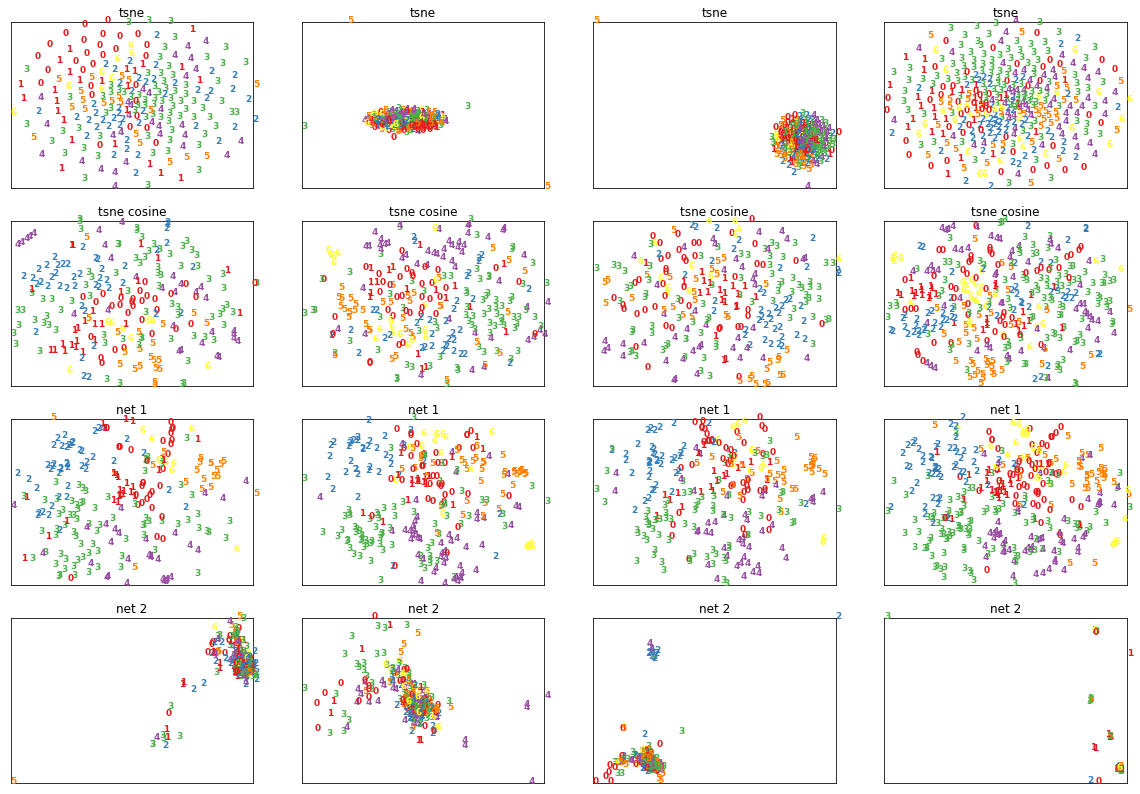

In [11]:
f, axarr = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(20, 14))
dim_red = DimReduction(n_components=2)

for i in range(4):
    G = dataset.all_train_data[i]
    labels = [int(l) for l in G.labels]
    X = G.data.view(G.data.shape[0], -1).numpy()
    
    # tsne
    embedder = TSNE(n_components=2, metric='euclidean', method='exact', perplexity=30, verbose=0)
    X_emb = embedder.fit_transform(X)
    plot_embedding_subplot(axarr[0,i], X_emb, labels=labels, title='tsne')
    
    # tsne
    embedder = TSNE(n_components=2, metric='cosine', method='exact', perplexity=30, verbose=0)
    X_emb_cos = embedder.fit_transform(X)
    plot_embedding_subplot(axarr[1,i], X_emb_cos, labels=labels, title='tsne cosine')
    
    # Net
    if torch.cuda.is_available():   
        y_pred = net_1.forward(G).cpu().detach().numpy()
    else:    
        y_pred = net_1.forward(G).detach().numpy()
    plot_embedding_subplot(axarr[2,i], y_pred, labels=labels, title='net 1')
    
    # Net
    if torch.cuda.is_available():   
        y_pred = net_2.forward(G).cpu().detach().numpy()
    else:    
        y_pred = net_2.forward(G).detach().numpy()
    plot_embedding_subplot(axarr[3,i], y_pred, labels=labels, title='net 2')
